##### Basado en código de Tensorflow.org

In [93]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Participantes

 - Alejandro Cortijo Benito
 - Alejandro García Mota

# Generative Adversarial Network

### Setup

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.18.0'

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-1873ykar
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-1873ykar
  Resolved https://github.com/tensorflow/docs to commit a81ff2e4ebf518b45cad643d88063c6f2b9e5a1e
  Preparing metadata (setup.py) ... done


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images) / 127.5 - 1  # Normalize the images to [-1, 1] to use tanh function
#plot.imshow normaliza los valores de la imagen antes de mostrarla

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128 # 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

In [ ]:
noise_dim = 64 #100

### The Generator


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7 * 7 * 128, input_shape=(64,)))
    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.01))

    # Capa de salida
    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding="same", activation="tanh"))

    return model

Use the (as yet untrained) generator to create an image.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 6272)                │         407,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 28, 28, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 28, 28, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 500,609 (1.91 MB)

 Trainable params: 500,417 (1.91 MB)

 Non-trainable params: 192 (768.00 B)

None


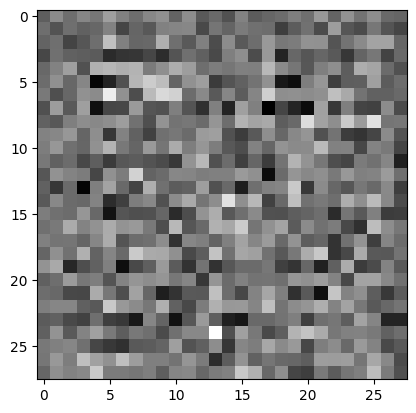

In [ ]:
generator = make_generator_model()

print (generator.summary())

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#normaliza los valores de la imagen antes de mostrarla

### The Discriminator


In [ ]:
def make_critical_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model


Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
critical = make_critical_model()
print (critical.summary())
decision = critical(generated_image)
print (decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19 (LeakyReLU)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 373,761 (1.43 MB)

 Trainable params: 373,761 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

None
tf.Tensor([[-0.00102873]], shape=(1, 1), dtype=float32)


The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
critical_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=critical_optimizer,
                                 generator=generator,
                                 discriminator=critical)

## Define the training loop


In [ ]:
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
def gradient_penalty(batch_size, real_images, fake_images):
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = real_images + alpha * (fake_images - real_images)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = critical(interpolated, training=True)

    grads = gp_tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)

    return gp

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

n_critic = 5
gp_weight = 10

@tf.function
def train_step(real_images):
    batch_size = real_images.shape[0]

    # ===========================
    # Entrenar Crítico
    # ===========================
    for _ in range(n_critic):
        random_latent_vectors = tf.random.normal([batch_size, 64])

        with tf.GradientTape() as tape:
            fake_images = generator(random_latent_vectors, training=True)

            fake_logits = critical(fake_images, training=True)
            real_logits = critical(real_images, training=True)

            d_loss = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

            gp = gradient_penalty(batch_size, real_images, fake_images)
            d_loss += gp * gp_weight

        d_gradient = tape.gradient(d_loss, critical.trainable_variables)
        critical_optimizer.apply_gradients(zip(d_gradient, critical.trainable_variables))

    # ===========================
    # Entrenar Generador
    # ===========================
    random_latent_vectors = tf.random.normal([batch_size, 64])

    with tf.GradientTape() as tape:
        fake_images = generator(random_latent_vectors, training=True)
        fake_logits = critical(fake_images, training=True)

        g_loss = -tf.reduce_mean(fake_logits)

    g_gradient = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_gradient, generator.trainable_variables))

    return d_loss, g_loss


In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            #print ("len image_batch:", len(image_batch))
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input, num_images=16):
    predictions = model(test_input, training=False)

    total_preds = predictions.shape[0]
    indices = tf.random.shuffle(tf.range(total_preds))[:num_images]
    selected_images = tf.gather(predictions, indices)

    # Cuadrícula dinámica para mostrar imágenes
    grid_size = int(np.ceil(np.sqrt(num_images)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))

    for ax, img in zip(axes.flat, selected_images):
        ax.imshow(img[:, :, 0] * 255, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'./{FOLDER}/image_at_epoch_{epoch:04d}.jpeg', format='jpeg')
    plt.show()

In [ ]:
FOLDER = 1

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

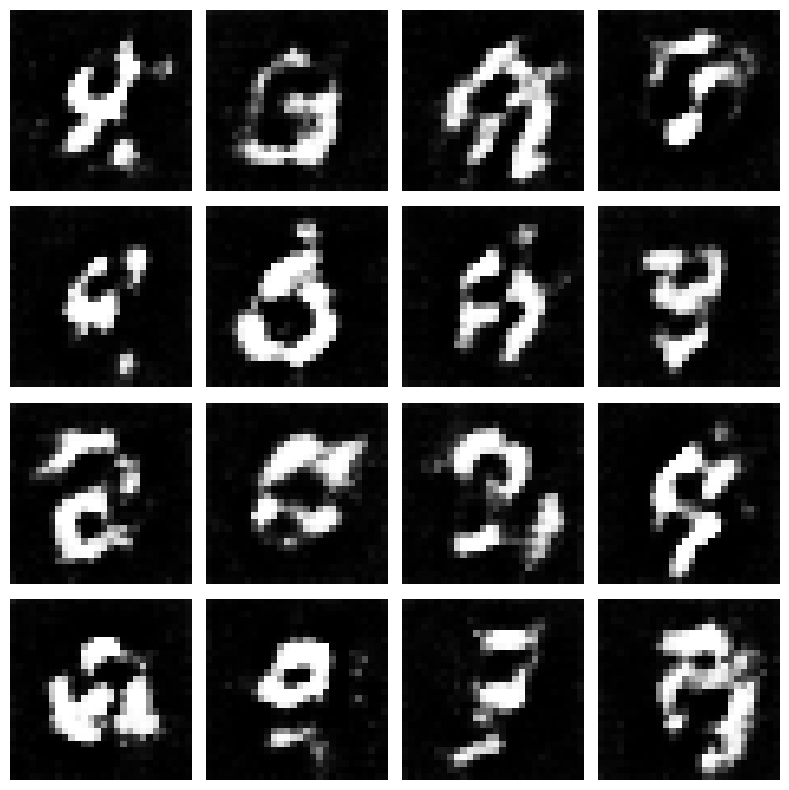

In [ ]:
#
EPOCHS = 1 # 50
train(train_dataset, EPOCHS)

In [ ]:
FOLDER = 2

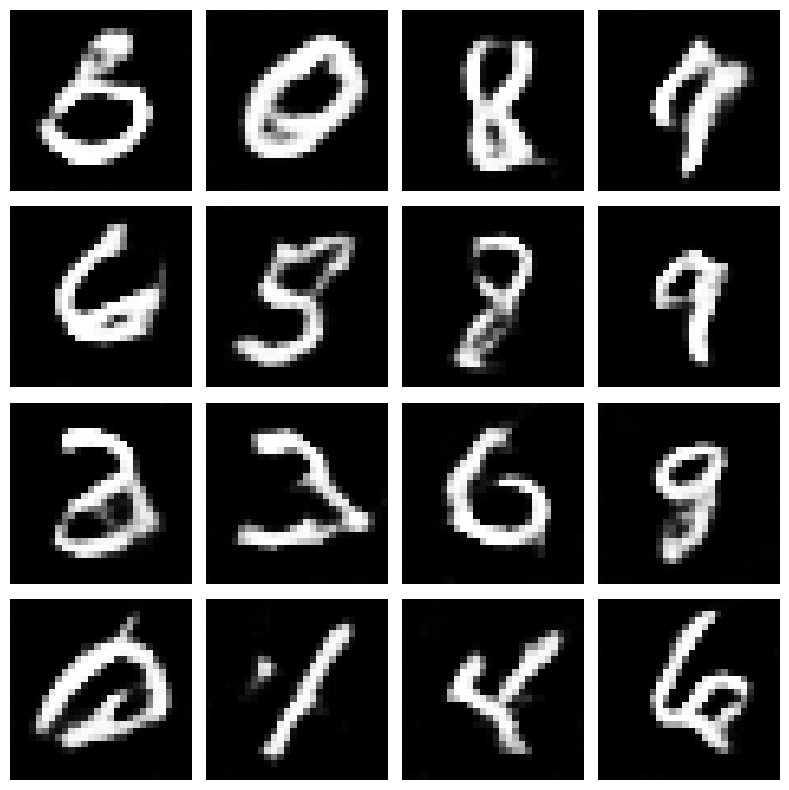

In [ ]:
#
EPOCHS = 10 # 50
train(train_dataset, EPOCHS)

In [ ]:
FOLDER = 3

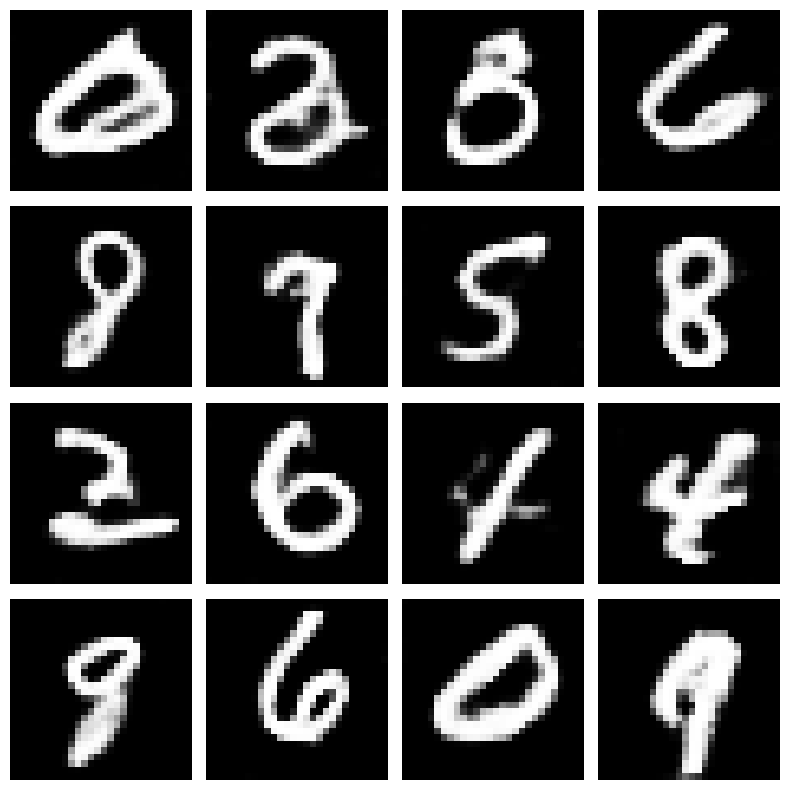

In [ ]:
#
EPOCHS = 30 # 50
train(train_dataset, EPOCHS)

In [ ]:
FOLDER = 4

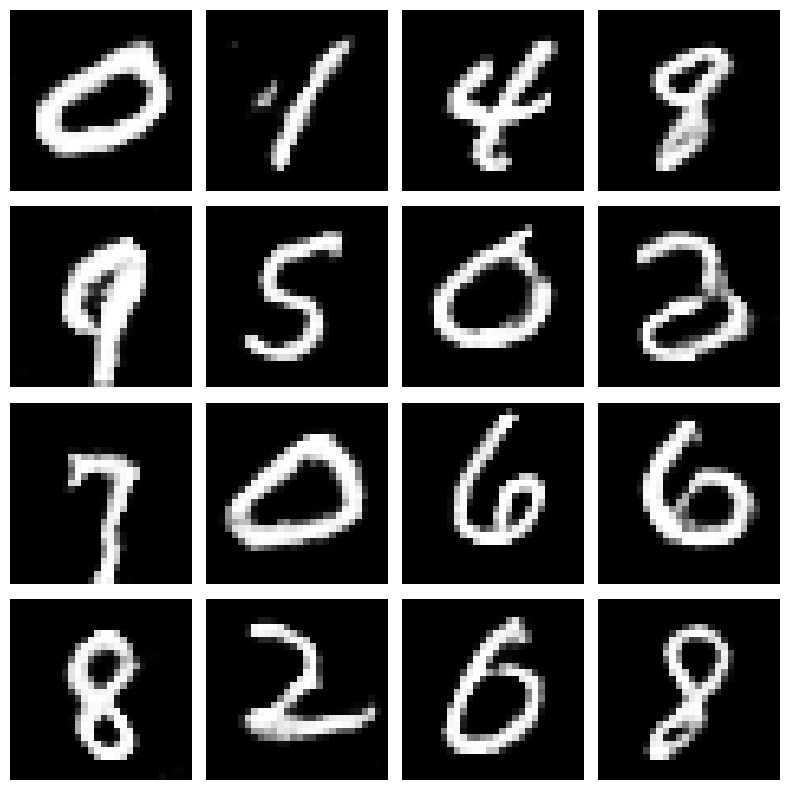

In [ ]:
#
EPOCHS = 50 # 50
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
def create_gif_from_folders(folder_list=['1', '2', '3', '4'], output_gif='wgan_gp_training_progress.gif', duration=0.7):
    all_images = []

    for folder in folder_list:
        image_files = sorted(glob.glob(os.path.join(folder, '*.jpeg')))
        all_images.extend(image_files)

    if all_images:
        with imageio.get_writer(output_gif, mode='I', duration=duration) as writer:
            for filename in all_images:
                image = imageio.imread(filename)
                writer.append_data(image)

        print(f'GIF guardado como {output_gif}')
    else:
        print("No se encontraron imágenes en las carpetas especificadas.")

create_gif_from_folders()

<ipython-input-123-06eaf170d622>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF guardado como combined_training_progress.gif


![Progreso del entrenamiento](wgan_combined_training_progress.gif)

## Comparación
    
WGAN aborda varios problemas que enfrentan las GAN y DCGAN. Las GAN tradicionales, que utilizan una función de pérdida basada en la entropía cruzada, suelen sufrir inestabilidad durante el entrenamiento y son propensas al colapso del modo, donde el generador produce un conjunto limitado de resultados. Esto se debe a que el discrimindor falla solo con algunas clases. Por otro lado, las DCGAN, al incorporar redes convolucionales profundas, mejoran la calidad de las imágenes generadas al aprovechar las convoluciones, pero aún enfrentan problemas similares de inestabilidad y colapso del modo.

En contraste, WGAN introduce la distancia de Wasserstein como métrica para la función de pérdida, lo que mejora significativamente la estabilidad del entrenamiento y reduce el colapso del modo. Además, WGAN reemplaza el discriminador con un crítico, lo que permite una mejor evaluación de la calidad de las imágenes generadas. También utiliza técnicas como el recorte de pesos o la penalización de gradiente para garantizar un entrenamiento más robusto y efectivo. De esta manera, WGAN supera las limitaciones de las GAN y DCGAN, ofreciendo un enfoque más estable y confiable para la generación de imágenes.